In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn import metrics

## Separação de dados

In [14]:
dados = pd.read_csv("Data/winequality-red.csv")
df_dados = pd.DataFrame(dados)

In [15]:
# shuffle the data and split it into train, validation and test sets
def ShuffleuSplit(df_dados):
    # shuffle data to avoid bias
    df_dados = shuffle(df_dados)

    # separe the last column in another variable
    df_dados_without_class = df_dados.drop(columns=["quality"])


    # split the data into train, validation and test sets
    x_treino, x_temp, y_treino, y_temp = train_test_split(
        df_dados_without_class,
        df_dados["quality"],
        test_size=0.5,
    )
    x_validacao, x_teste, y_validacao, y_teste = train_test_split(
        x_temp, y_temp, test_size=0.5
    )

    # print("Treino")
    # x_treino.info()
    # y_treino.info()

    # print("\nValidação")
    # x_validacao.info()
    # y_validacao.info()

    # print("\nTeste")
    # x_teste.info()
    # y_teste.info()
    
    return (
        x_treino,
        y_treino,
        x_validacao,
        y_validacao,
        x_teste,
        y_teste,
    )

# Statistical Analisys

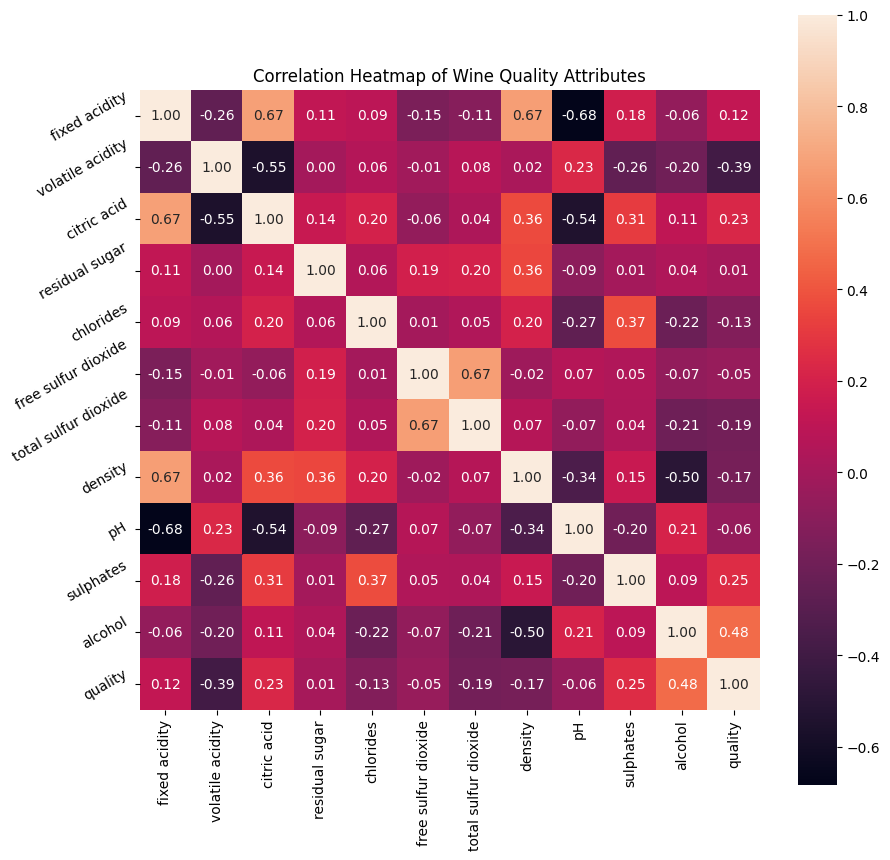

In [16]:
#Pearson Correlation in df_dados
cor = df_dados.corr()

#Print the heat map
plt.figure(figsize=(10,10))
plt.title('Correlation Heatmap of Wine Quality Attributes')
a = sns.heatmap(cor, square=True, annot=True, fmt='.2f'
                #, linecolor='black'
                )
a.set_xticklabels(a.get_xticklabels(), rotation=90)
a.set_yticklabels(a.get_yticklabels(), rotation=30)
plt.show()
#Create an txt archive to save
f = open("Data/df_dados.txt", "w")

#Save the matrix of correlation in txt archive
f.write("Matriz de correlação do df_dados: \n")
f.write(str(cor))
f.write("\n")
#Save the size of df_dados in txt archive
f.write("Tamanho do df_dados: \n")
f.write(str(df_dados.shape))
f.write("\n")
#Save the dimension of df_dados in txt archive
f.write("Dimensão do df_dados: \n")
f.write(str(df_dados.ndim))
f.write("\n")
#Save the number of classes in df_dados in txt archive
f.write("Número de classes do df_dados: \n")
f.write(str(df_dados['quality'].nunique()))
f.write("\n")
#Save the type of atributtes in df_dados in txt archive
f.write("Tipo dos atributos do df_dados: \n")
f.write(str(df_dados.dtypes))
f.write("\n")
#Save the average values ​​of each attribute in df_dados in txt archive
f.write("Valor médio de cada atributo do df_dados: \n")
f.write(str(df_dados.mean()))
f.write("\n")
#Save the maximum values ​​of each attribute in df_dados in txt archive
f.write("Valor máximo de cada atributo do df_dados: \n")
f.write(str(df_dados.max()))
f.write("\n")
#Save the minimum values ​​of each attribute in df_dados in txt archive
f.write("Valor mínimo de cada atributo do df_dados: \n")
f.write(str(df_dados.min()))
f.write("\n")
#Close the txt archive
f.close()

# KNR

In [17]:
from sklearn.neighbors import KNeighborsRegressor

def grid_search_KNN_regression(x_treino, y_treino, x_validacao, y_validacao):
    best_rmse = float('inf')
    best_k = -1
    best_distance_metric = ""
    best_KNN = None

    for k in range(1, 50, 2):
        for distance_metric in ["uniform", "distance"]:
            knn_instance = KNeighborsRegressor(
                n_neighbors=k, weights=distance_metric
            )
            knn_instance.fit(x_treino, y_treino)
            knn_validation_pred = knn_instance.predict(x_validacao)
            mse = mean_squared_error(y_validacao, knn_validation_pred)
            rmse = np.sqrt(mse)

            if rmse < best_rmse:
                best_rmse = rmse
                best_k = k
                best_distance_metric = distance_metric
                best_KNN = knn_instance

    return best_KNN, best_k, best_distance_metric


def KNN_regression(x_treino, y_treino, x_validacao, y_validacao, x_teste, y_teste):
    best_KNN, best_k, best_distance_metric = grid_search_KNN_regression(
        x_treino, y_treino, x_validacao, y_validacao
    )

    knn_test_pred = best_KNN.predict(x_teste)
    test_mse = mean_squared_error(y_teste, knn_test_pred)
    test_rmse = np.sqrt(test_mse)

    return test_rmse, best_KNN, best_k, best_distance_metric

# SVR

In [18]:
from sklearn.svm import SVR

def grid_search_SVM_regression(x_treino, y_treino, x_validacao, y_validacao):
    param_grid = {
        "C": [0.1, 1.0, 10.0],  # Define C values
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
    }

    best_rmse = float('inf')
    best_params = None
    best_SVM = None

    for params in ParameterGrid(param_grid):
        svm_instance = SVR(**params)
        svm_instance.fit(x_treino, y_treino)
        svm_validation_pred = svm_instance.predict(x_validacao)
        mse = mean_squared_error(y_validacao, svm_validation_pred)
        rmse = np.sqrt(mse)

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
            best_SVM = svm_instance

    return best_SVM, best_params


def SVM_regression(x_treino, y_treino, x_validacao, y_validacao, x_teste, y_teste):
    best_SVM, best_params = grid_search_SVM_regression(
        x_treino, y_treino, x_validacao, y_validacao
    )

    svm_test_pred = best_SVM.predict(x_teste)
    test_mse = mean_squared_error(y_teste, svm_test_pred)
    test_rmse = np.sqrt(test_mse)

    return test_rmse, best_SVM, *best_params

# MLP

In [19]:
from sklearn.neural_network import MLPRegressor

def grid_search_MLP_regression(x_treino, y_treino, x_validacao, y_validacao):
    param_grid = {
        "hidden_layer_sizes": [
            (100,),
            (50, 50),
            (100, 50, 25),
        ],  # Define hidden_layer_sizes
        "activation": ["identity", "logistic", "tanh", "relu"],
        "max_iter": [1000, 2000],  # Define max_iter values
        "learning_rate": ["constant", "invscaling", "adaptive"],
    }

    best_rmse = float('inf')
    best_params = None
    best_MLP = None

    for params in ParameterGrid(param_grid):
        mlp_instance = MLPRegressor(**params)
        mlp_instance.fit(x_treino, y_treino)
        mlp_validation_pred = mlp_instance.predict(x_validacao)
        mse = mean_squared_error(y_validacao, mlp_validation_pred)
        rmse = np.sqrt(mse)

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
            best_MLP = mlp_instance

    return best_MLP, best_params


def MLP_regression(x_treino, y_treino, x_validacao, y_validacao, x_teste, y_teste):
    best_MLP, best_params = grid_search_MLP_regression(
        x_treino, y_treino, x_validacao, y_validacao
    )

    mlp_test_pred = best_MLP.predict(x_teste)
    test_mse = mean_squared_error(y_teste, mlp_test_pred)
    test_rmse = np.sqrt(test_mse)

    return test_rmse, best_MLP, *best_params

# RF

In [20]:
from sklearn.ensemble import RandomForestRegressor

def grid_search_RF_regression(x_treino, y_treino, x_validacao, y_validacao):
    param_grid = {
        "n_estimators": [10, 50, 100],  # Define n_estimators values
        "criterion": ["friedman_mse", "absolute_error", "squared_error"],  # Define Criterion values
        "max_depth": [None, 10, 50],  # Define max_depth values
        "min_samples_split": [2, 5, 10],  # Define min_samples_split values
        "min_samples_leaf": [1, 2, 4],  # Define min_samples_leaf values
    }

    best_rmse = float('inf')
    best_params = None
    best_RF = None

    for params in ParameterGrid(param_grid):
        rf_instance = RandomForestRegressor(**params)
        rf_instance.fit(x_treino, y_treino)
        rf_validation_pred = rf_instance.predict(x_validacao)
        mse = mean_squared_error(y_validacao, rf_validation_pred)
        rmse = np.sqrt(mse)

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
            best_RF = rf_instance

    return best_RF, best_params


def RF_regression(x_treino, y_treino, x_validacao, y_validacao, x_teste, y_teste):
    best_rf, best_params = grid_search_RF_regression(
        x_treino, y_treino, x_validacao, y_validacao
    )

    rf_test_pred = best_rf.predict(x_teste)
    test_mse = mean_squared_error(y_teste, rf_test_pred)
    test_rmse = np.sqrt(test_mse)

    return test_rmse, best_rf, *best_params

# GB

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

def grid_search_GB_regression(x_treino, y_treino, x_validacao, y_validacao):
    param_grid = {
        "n_estimators": [10, 50, 100],  # Define n_estimators values
        "loss": ["squared_error", "quantile", "absolute_error", "huber"],  # Define loss values
        "max_depth": [None, 10, 50],  # Define max_depth values
        "learning_rate": [0.1, 0.5, 1.0],  # Define learning_rate values
        "min_samples_split": [2, 5, 10],  # Define min_samples_split values
        "min_samples_leaf": [1, 2, 4],  # Define min_samples_leaf values
    }

    best_rmse = float('inf')
    best_params = None
    best_GB = None

    for params in ParameterGrid(param_grid):
        gb_instance = GradientBoostingRegressor(**params)
        gb_instance.fit(x_treino, y_treino)
        gb_validation_pred = gb_instance.predict(x_validacao)
        mse = mean_squared_error(y_validacao, gb_validation_pred)
        rmse = np.sqrt(mse)

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
            best_GB = gb_instance

    return best_GB, best_params


def GB_regression(x_treino, y_treino, x_validacao, y_validacao, x_teste, y_teste):
    best_gb, best_params = grid_search_GB_regression(
        x_treino, y_treino, x_validacao, y_validacao
    )

    gb_test_pred = best_gb.predict(x_teste)
    test_mse = mean_squared_error(y_teste, gb_test_pred)
    test_rmse = np.sqrt(test_mse)

    return test_rmse, best_gb, *best_params

# MLR

In [22]:
from sklearn.linear_model import LinearRegression

#Create a function to calculate the multiple linear regression and retorn the root mean-square error
def LinearRegressionMultiple(x_treino, y_treino, x_validacao, y_validacao, x_teste, y_teste):
    #Create a linear regression model
    model = LinearRegression()
    #Train the model
    model.fit(x_treino, y_treino)
    #Predict the model
    y_pred = model.predict(x_validacao)
    #Calculate the root mean-square error using
    rmse = np.sqrt(np.mean((y_pred - y_validacao) ** 2))
    #Return the root mean-square error
    return rmse

# Main

In [23]:
# O que falta fazer: Pedir para o Gepeto quais os melhores parâmetros para cada modelo e colocar no grid search
# Pedir para o Gepeto explicar a matriz de correlação obtida


output = pd.DataFrame(columns=["KNR", "SVR", "MLP", "RF", "GB", "MLR"])

knr_best_params = pd.DataFrame(columns=["K", "Distance Metric"])
svr_best_params = pd.DataFrame(columns=["C", "kernel"])
mlp_best_params = pd.DataFrame(
    columns=["hidden_layer_sizes", "activation", "max_iter", "learning_rate"]
)
rf_best_params = pd.DataFrame(
    columns=[
        "n_estimators",
        "criterion",
        "max_depth",
        "min_samples_split",
        "min_samples_leaf",
    ]
)
gb_best_params = pd.DataFrame(
    columns=[
        "n_estimators",
        "loss",
        "learning_rate",
        "max_depth",
        "min_samples_split",
        "min_samples_leaf",
    ]
)

for i in range(20):
    # shuffle and split the data
    shuffled_data = ShuffleuSplit(df_dados)

    # KNR Execution
    knr_rsme, knr_model, *knr_params = KNN_regression(*shuffled_data)
    knr_best_params.loc[len(knr_best_params.index)] = knr_params

    # show confusion matrix for KNN
    # knn_test_pred = knr_model.predict(shuffled_data[4])
    # print("\nKNN Confusion Matrix:")
    # print("Accuracy: ", knr_rsme)
    # print(metrics.confusion_matrix(shuffled_data[5], knn_test_pred))

    # SVR Execution
    svr_rsme, svr_model, *svr_params = SVM_regression(*shuffled_data)
    svr_best_params.loc[len(svr_best_params.index)] = svr_params

    # show confusion matrix for SVM
    # svm_test_pred = svr_model.predict(shuffled_data[4])
    # print("\nSVM Confusion Matrix:")
    # print("Accuracy: ", svr_rsme)
    # print(metrics.confusion_matrix(shuffled_data[5], svm_test_pred))

    # MLP Execution
    mlp_rsme, mlp_model, *mlp_params = MLP_regression(*shuffled_data)
    mlp_best_params.loc[len(mlp_best_params.index)] = mlp_params

    # show confusion matrix for MLP
    # mlp_test_pred = mlp_model.predict(shuffled_data[4])
    # print("\nMLP Confusion Matrix:")
    # print("Accuracy: ", mlp_rsme)
    # print(metrics.confusion_matrix(shuffled_data[5], mlp_test_pred))

    # RF Execution
    rf_rsme, rf_model, *rf_params = RF_regression(*shuffled_data)
    rf_best_params.loc[len(rf_best_params.index)] = rf_params

    # show confusion matrix for RF
    # rf_test_pred = rf_model.predict(shuffled_data[4])
    # print("\nRF Confusion Matrix:")
    # print("Accuracy: ", rf_rsme)
    # print(metrics.confusion_matrix(shuffled_data[5], rf_test_pred))

    # GB Execution
    gb_rsme, gb_model, *gb_params = GB_regression(*shuffled_data)
    gb_best_params.loc[len(gb_best_params.index)] = gb_params

    # show confusion matrix for GB
    # gb_test_pred = gb_model.predict(shuffled_data[4])
    # print("\nGB Confusion Matrix:")
    # print("Accuracy: ", gb_rsme)
    # print(metrics.confusion_matrix(shuffled_data[5], gb_test_pred))

    # MLR Execution
    mlr_rmse = LinearRegressionMultiple(*shuffled_data)

    # add accuracies to output
    output.loc[len(output.index)] = [
        knr_rsme,
        svr_rsme,
        mlp_rsme,
        rf_rsme,
        gb_rsme,
        mlr_rmse,
    ]

    # print current index and current line
    print("============================================")
    print(
        i,
        ":",
        [knr_rsme, svr_rsme, mlp_rsme, rf_rsme, gb_rsme, mlr_rmse],
    )
    print("============================================")


# generate csv from knn best params, ignoring the index columns
knr_best_params.to_csv("best_params/knn.csv", index=False)
mlp_best_params.to_csv("best_params/mlp.csv", index=False)
svr_best_params.to_csv("best_params/svm.csv", index=False)
rf_best_params.to_csv("best_params/rf.csv", index=False)
gb_best_params.to_csv("best_params/gb.csv", index=False)

# generate csv from output, ignoring the index columns
output.to_csv("output.csv", index=False)

0 : [0.6986695196876775, 0.6315931309926934, 0.6298744700572455, 0.5767440940313131, 0.5968111075676027, 0.6802950440563127]
1 : [0.732204963561879, 0.6670300854170311, 0.6646831017926845, 0.6115461961291232, 0.6296404275726661, 0.6591790421677556]
2 : [0.672900103402748, 0.6215665430964974, 0.6172222320226858, 0.5855960832296248, 0.5846750945085889, 0.6341894034783319]
3 : [0.7032445521757951, 0.6852438910638566, 0.6595419444406314, 0.6385992179083695, 0.621552420674179, 0.6650031766996799]
4 : [0.730798137862291, 0.6565559496048411, 0.6538563470254416, 0.6134142156813779, 0.6179461827397827, 0.6861349104450658]
5 : [0.7617073956106144, 0.6568239899435462, 0.6411914016150713, 0.6050396681210249, 0.6131623085946042, 0.6446785569849101]
6 : [0.6891825383330025, 0.6295320025260435, 0.6321581246276075, 0.5680568304414393, 0.5973162302852982, 0.6326516432554029]
7 : [0.7525575110982761, 0.6747594830246008, 0.6814400038546375, 0.6389051181513574, 0.6693183969317192, 0.6304095248562318]
8 : 